In [1]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import scipy.optimize as optimize

# bypass UsageError when there is no GUI
try:
    %matplotlib inline
except:
    pass

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 16
plt.style.use('ggplot')

In [60]:
DataStructure = namedtuple('DataStructure', 'hopg_down hopg_up au_1 au_2')
data = DataStructure(
    hopg_down = {
        'file': './raw/HOPG-DOWN.txt',
        'dim': np.linspace(0, 2, 100),
        'title': 'HOPG downwards',
        'name': 'down',
        'preselection': {
            'x': [1.05, 2],
            'y': [1.48, 2],
        },
        'bounds': [[[0.3, 0.3], [0.3, 0.1]],
                   [[-0.85, 1.4], [-0.85, 1.2]],
#                   [[-100, 46], [-100, 32]],
                  ],
        'anker': 32,
    },
    hopg_up = {
        'file': './raw/HOPG-UP.txt',
        'dim': np.linspace(0, 2, 100),
        'title': 'HOPG upwards',
        'name': 'up',
        'preselection': {
            'x': [0.872, 2],
            'y': [1.75, 2],
        },
        'bounds': [[[0.35, 0.7], [0.35, 0.48]],
                   [[-0.85, 1.4], [-0.85, 1.2]],
#                   [[-20, 9], [-20, 6]],
                  ],
        'anker': 33,
    },
    au_1 = {
        'file': './raw/AU-1-1.txt',
        'dim': np.linspace(0, 300, 512),
        'title': '1. AU',
        'name': 'au1',
    },
    au_2 = {
        'file': './raw/AU-2-2.txt',
        'dim': np.linspace(0, 300, 512),
        'title': '2. AU',
        'name': 'au2',
    }
)

for obj in data:
    im_data = np.genfromtxt(obj['file'])
    im_data = np.flipud(im_data)
    obj['data'] = im_data

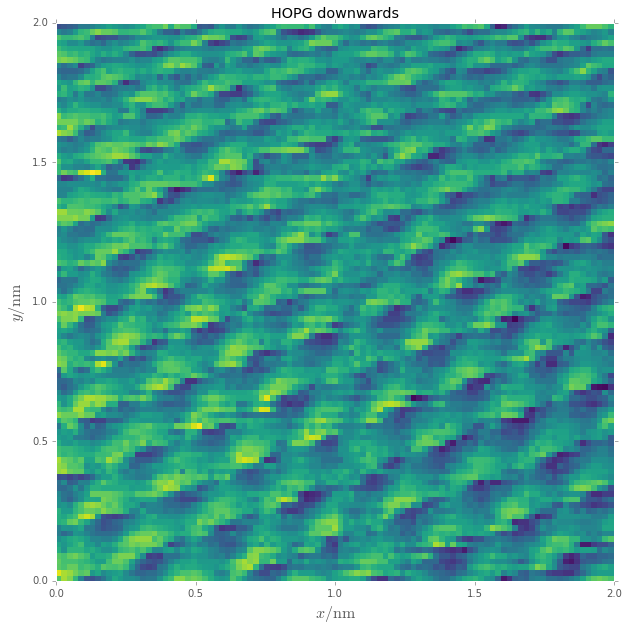

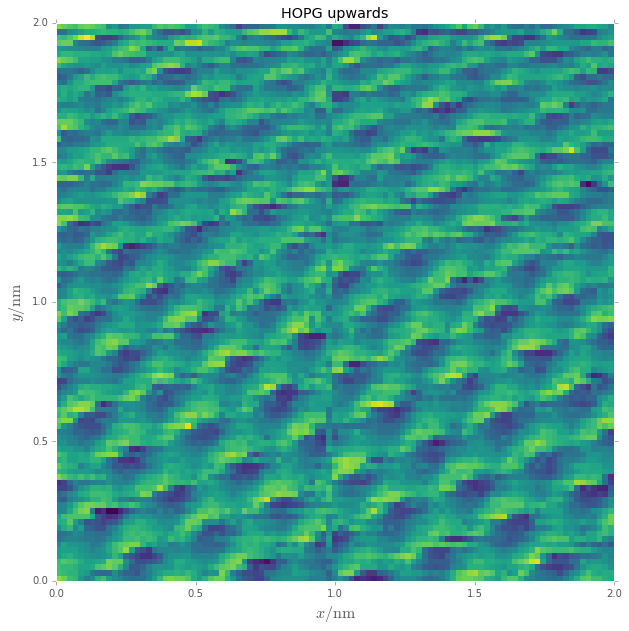

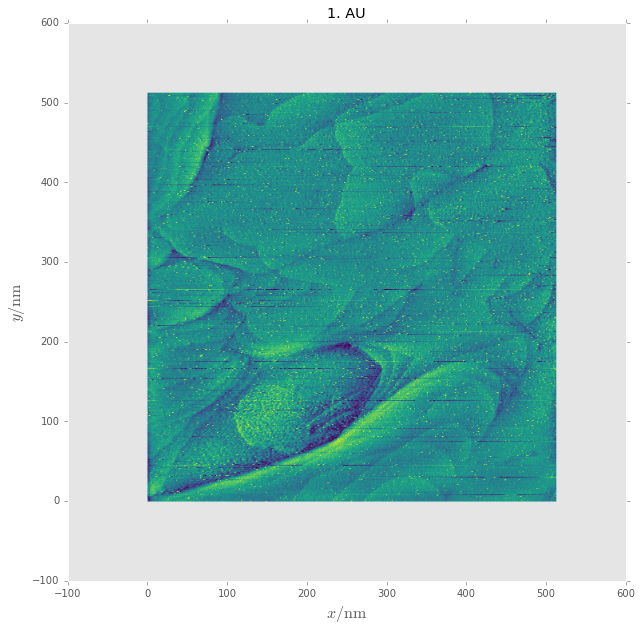

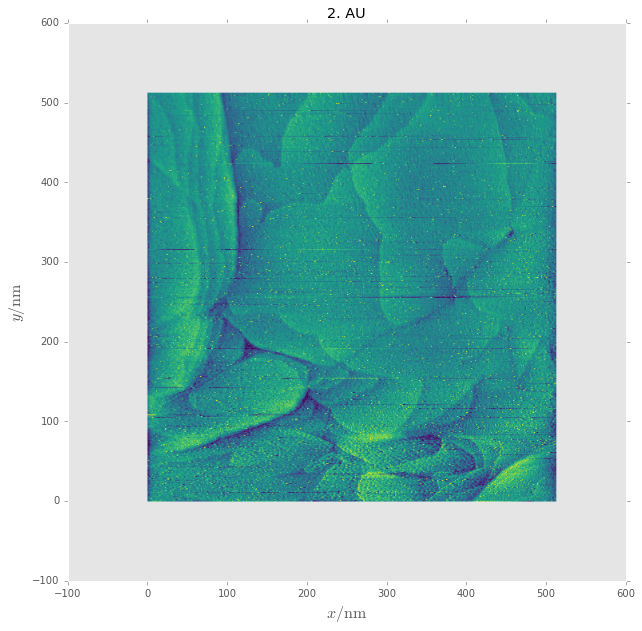

In [61]:
for i, obj in enumerate(data):
    plt.figure(figsize=(10, 10))
    if(obj['dim'].size > 200):
        plt.imshow(obj['data'], origin='lower')
        plt.grid(b=False)
    else:
        plt.pcolormesh(obj['dim'], obj['dim'], obj['data'])
    plt.title(obj['title'])
    plt.xlabel(r'$x / \mathrm{nm}$', fontsize=16)
    plt.ylabel(r'$y / \mathrm{nm}$', fontsize=16)
    plt.axis('equal')
    plt.savefig('build/plots/{}.pdf'.format(obj['title'].replace(' ', '_')))
    plt.show()

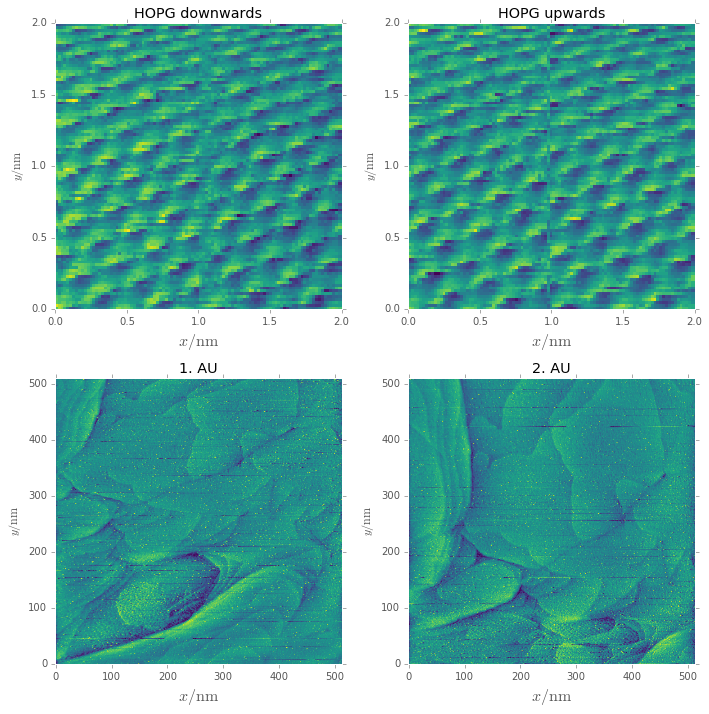

In [62]:
plt.figure(figsize=(10, 10))
for i, obj in enumerate(data):
    ax = plt.subplot(220 + i + 1, aspect='equal')
    if(obj['dim'].size > 200):
        plt.imshow(obj['data'], origin='lower')
        plt.grid(b=False)
    else:
        plt.pcolormesh(obj['dim'], obj['dim'], obj['data'])
    plt.title(obj['title'])
    plt.xlabel(r'$x / \mathrm{nm}$', fontsize=16)
    plt.ylabel(r'$y / \mathrm{nm}$')
plt.tight_layout()
plt.savefig('build/plots/all_plots.pdf')
plt.show()

In [63]:
def linear_func(x, a, b):
    return np.array(a) * x + b

Finde lokale Maxima und Plotte diese

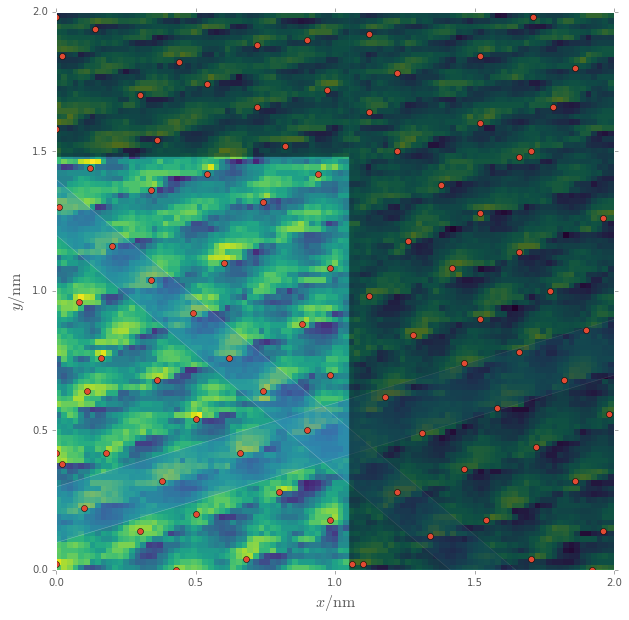

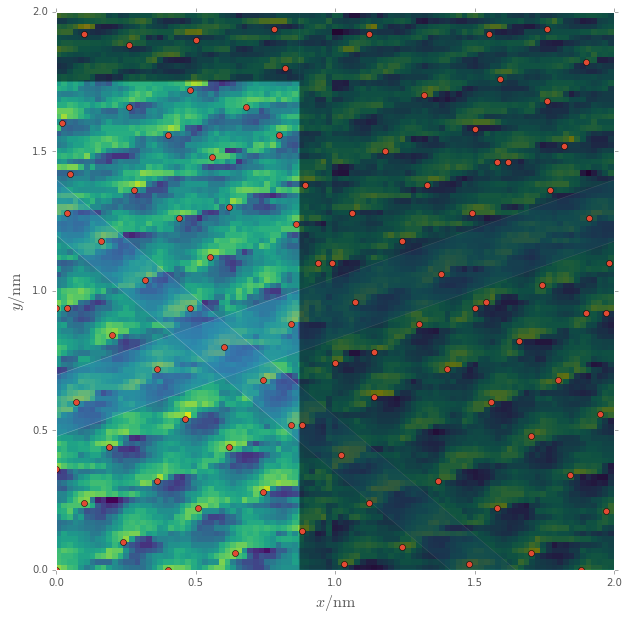

In [64]:
# took this from http://stackoverflow.com/a/9113227

neighbourhood_size = 12
threshhold = 1e-11

for data_slice, name in [[data.hopg_down, 'down'], [data.hopg_up, 'up']]:
    ds = data_slice['data']
    bounds = data_slice['bounds']
    preselection = data_slice['preselection']
    d_maxima = filters.maximum_filter(ds, neighbourhood_size)
    maxima = (ds == d_maxima)
    d_min = filters.minimum_filter(ds, neighbourhood_size)
    diff = ((d_maxima - d_min) > threshhold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/100
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/100  
        y.append(y_center)
    data_slice['xy'] = np.array([x, y])

    plt.figure(figsize=(10, 10))
    plt.pcolormesh(data_slice['dim'], data_slice['dim'], data_slice['data'])
    plt.plot(np.array(x), np.array(y), 'o')
    plt.xlabel(r'$x/\mathrm{nm}$', fontsize=16)
    plt.ylabel(r'$y/\mathrm{nm}$', fontsize=16)
    plt.axis('equal')
    plt.xlim(0, 2)
    plt.ylim(0, 2)

    xs = np.linspace(0, 2, 10000)
    for u, l in bounds:
        plt.fill_between(xs, linear_func(xs, *l), linear_func(xs, *u), alpha=0.4)
    plt.fill_between(xs[xs < preselection['x'][0]],
                     preselection['y'][0],
                     2, alpha=0.5, edgecolor='none', facecolor='k')
    plt.fill_betweenx(xs, preselection['x'][0], 2, alpha=0.5, edgecolor='none', facecolor='k')
    plt.savefig('build/plots/hopg_{}_selection.pdf'.format(name))
    plt.show()

Fitte lineare Funktion an die Messpunkte innerhalb der Selektion. Berechne aus der Steigung die Richtung der Gittervektoren und skaliere die Länge auf die Zahl der für den Fit genutzten Gittervektoren.

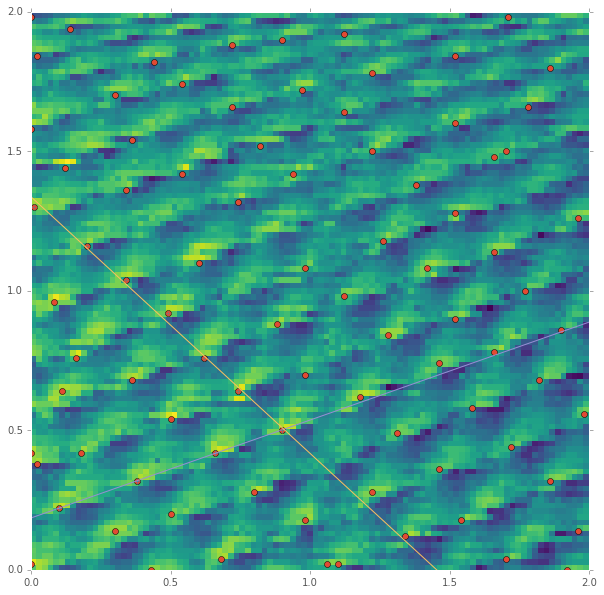

50.0


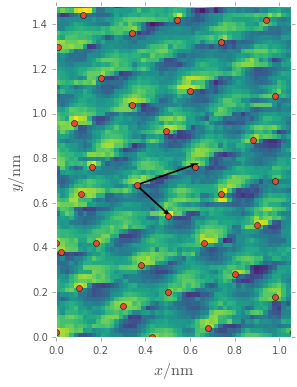

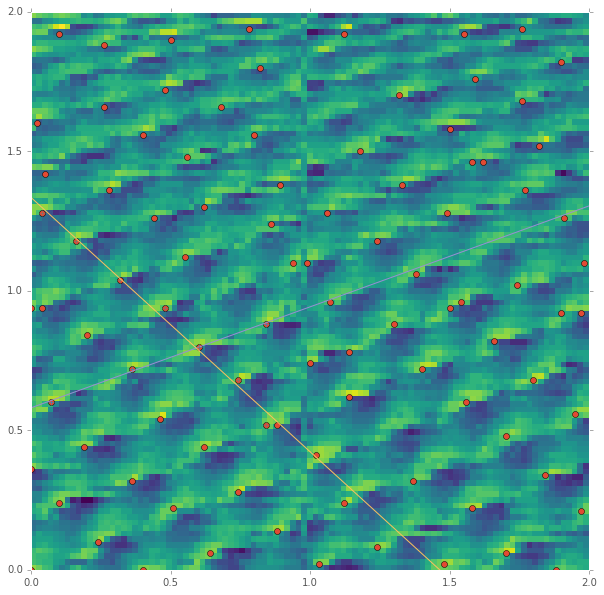

50.0


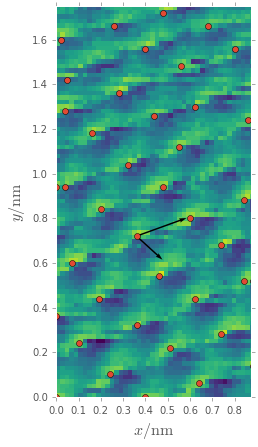

In [65]:
for data_slice, name in [[data.hopg_down, 'down'], [data.hopg_up, 'up']]:
    bounds = data_slice['bounds']
    preselection = data_slice['preselection']
    x, y = data_slice['xy']
    gvs = []
    p = data_slice['anker']
    try:
        invert = data_slice['invert-fit']
    except:
        invert = False

    plt.figure(figsize=(10, 10))
    plt.pcolormesh(data_slice['dim'], data_slice['dim'], data_slice['data'])
    plt.plot(np.array(x), np.array(y), 'o')
    for u, l in bounds:
        selection = (
            (y < linear_func(x, *u)) 
            & (y > linear_func(x, *l)) 
            & (np.array(x) < preselection['x'][0]) 
            & (np.array(y) < preselection['y'][0])
        )
        fit_xs = np.array(x)[selection]
        fit_ys = np.array(y)[selection]
        plt.plot(fit_xs, fit_ys, '+')

        if invert:
            a = fit_xs
            fit_xs = fit_ys
            fit_ys = a
        coeff, cov = optimize.curve_fit(linear_func, fit_xs, fit_ys)
        if invert:
            coeff = [1 / coeff[0], - coeff[1] / coeff[0]]
        errs = np.sqrt(np.diag(cov))
        dx = (np.max(fit_xs) - np.min(fit_xs)) / (len(fit_xs) - 1)
        if invert:
            gvs.append([1/coeff[0] * dx, dx])
        else:
            gvs.append([dx, coeff[0] * dx])
        xs = np.linspace(0, 2)
        plt.plot(xs, linear_func(xs, *coeff))
        plt.xlim(0, 2)
        plt.ylim(0, 2)
    plt.show()
        
    gvs = np.array(gvs)
    data_slice['gvs'] = gvs

    data_scale = len(data_slice['dim']) / np.max(data_slice['dim'])
    print(data_scale)
    plt.figure(figsize=(preselection['x'][0] * 4, preselection['y'][0] * 4))
    plt.pcolormesh(data_slice['dim'], data_slice['dim'], data_slice['data'])
    plt.plot(np.array(x), np.array(y), 'o')
    plt.quiver(x[p], y[p], gvs[:,0], gvs[:,1], scale=1)
    #for i in range(len(gvs)):
    #    plt.arrow(x[p], y[p], gvs[i][0], gvs[i][1], width=0.01, length_includes_head=True, head_width=0.03, fc='w')
    # annotate with indices if neccessary
    #for i, xy in enumerate(zip(x, y)):
    #    plt.annotate(i, xy)
    plt.xlabel(r'$x/\mathrm{nm}$', fontsize=16)
    plt.ylabel(r'$y/\mathrm{nm}$', fontsize=16)
    plt.xlim(0, preselection['x'][0])
    plt.ylim(0, preselection['y'][0])
    plt.savefig('build/plots/hopg_{}_arrows.pdf'.format(name))
    plt.show()

Speichere Vektoren nach `build/tex/`

In [66]:
for data_slice, name in [[data.hopg_down, 'down'], [data.hopg_up, 'up']]:
    for g, i, lt in zip(data_slice['gvs'], ['a', 'b', 'c'], [r'\vec{a}_1', r'\vec{a}_2', r'\vec{b}']):
        with open('build/tex/{}_vec_{}.tex'.format(name, i), 'w') as f:
            f.write(r'''{} =
            \begin{{pmatrix}}
                \SI{{{:.3f}}}{{\angstrom}}\\
                \SI{{{:.3f}}}{{\angstrom}}
            \end{{pmatrix}}'''
            .format(lt, *(g * 10)))
        with open('build/tex/{}_vec_{}_len.tex'.format(name, i), 'w') as f:
            f.write(r'''\left|{}\right| = \SI{{{:.3f}}}{{\angstrom}}'''
            .format(lt, np.linalg.norm(g) * 10))

Winkel für HOPG berechnen und speichern

In [68]:
for i, dataset in enumerate(data[:2]):
    name = dataset['name']
    title = dataset['title']
    gv1, gv2 = dataset['gvs']
    angle = np.arccos(gv1.dot(gv2) / np.sqrt(np.linalg.norm(gv1) * np.linalg.norm(gv2))) * 180 / np.pi
    dataset['angle'] = angle
    with open('build/tex/{}_angle.tex'.format(name), 'w') as f:
        f.write(r'''\angle\left(\vec{{a}}_1,\vec{{a}}_2\right) =
        \SI{{{:.1f}}}{{\degree}}'''.format(angle))

In [41]:
# transform the coordiantes
""" wrong!
a_vec = np.array(data.hopg_down['gvs'][0])
a_vec2 = np.array(data.hopg_down['gvs'][1])
b_vec = np.array(data.hopg_down['gvs'][2])

a_lit = 0.2461
b_lit = 0.6708

y_scale = np.sqrt(np.abs((b_lit**2 * a_vec[0]**2 - a_lit**2 * b_vec[0]**2) /
           (a_vec[0]**2 * b_vec[1]**2 - a_vec[1]**2 * b_vec[0]**2)))
x_scale = np.sqrt(np.abs((a_lit**2 - y_scale**2 * a_vec[1]**2) / (a_vec[0]**2)))

s = np.array([x_scale, y_scale])

print(s)

print(np.sqrt(np.sum(a_vec**2 * np.array(x_scale, y_scale)**2)))
print(np.sqrt(np.sum(b_vec**2 * np.array(x_scale, y_scale)**2)))

print(np.arccos(np.sum(s**2 * a_vec * a_vec2) / np.sqrt(np.sum(s**2 * a_vec**2) * np.sum(s**2 * a_vec2**2))) * 180/np.pi)

plt.figure(figsize=(13,8))
for v in [a_vec, a_vec2, b_vec]:
    plt.arrow(1.8, 1.8, *(v * np.array([x_scale, y_scale])), width=0.01, length_includes_head=True, head_width=0.03, fc='w')
plt.pcolormesh(data.hopg_down['dim'] * x_scale, data.hopg_down['dim'] * y_scale, data.hopg_down['data'])
plt.show()
""";